# Computer Lab 2: Time Series Cross Validation

**In this computer lab practical you will learn**

* How to apply time series cross validation to select the best forecasting model.

To keep things simple we will work with naive forecasting models.

# Standard Imports

In [1]:
import pandas as pd
import numpy as np

# Forecast-tools imports

In [2]:
from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error

# Exercise 1: Implementing rolling forecast origin time series cross validation.

# Exercise 1.1: Load the data

**Task**:

* Import monthly outpatient appointments time series. This can be found in **"out_appoints_mth.csv"**

**Hints:** 
* This is monthly data.  You can use the Monthly Start ('MS') frequency

In [3]:
# your code here ...

In [4]:
appoints = pd.read_csv('../../../hpdm097-data/forecasting/out_appoints_mth.csv', 
                   index_col='date', parse_dates=True, dayfirst=True)
appoints.index.freq = 'MS'

In [5]:
appoints.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2014-04-01 to 2018-04-01
Freq: MS
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   out_apts  49 non-null     int64
dtypes: int64(1)
memory usage: 784.0 bytes


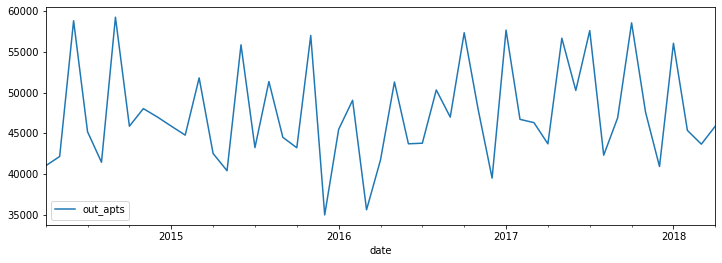

In [6]:
appoints.plot(figsize=(12,4))

# Exercise 1.2. Create a rolling forecast origin in a loop.

In rolling forecast origin we iteratively move our model into the future.  Assume we have the following training data.

```python
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
``` 

If we initially train our model on the first 5 data points and make a 1 step forecast, then a rolling forecast origin look like this:

```python
[1] train => [1, 2, 3, 4, 5], test => [6]
[2] train => [1, 2, 3, 4, 5, 6], test => [7]
[3] train => [1, 2, 3, 4, 5, 6, 7], test => [8]
[4] train => [1, 2, 3, 4, 5, 6, 7, 8], test => [9]
[5] train => [1, 2, 3, 4, 5, 6, 7, 8, 9], test => [10]
``` 

If instead we had a forecast horizon of 2 then our splits would look like:
```python
[1] train => [1, 2, 3, 4, 5], test => [6, 7]
[2] train => [1, 2, 3, 4, 5, 6], test => [7, 8]
[3] train => [1, 2, 3, 4, 5, 6, 7], test => [8, 9]
[4] train => [1, 2, 3, 4, 5, 6, 7, 8], test => [9, 10]
``` 

There are different ways to implement this in Python.  The simplest is to use a for loop.

**Task:**
    
* Code a rolling forecast origin for-loop that returns a `train` and `test` in each iteration of a training data input.
* In each cv-fold the length of test should be equal to a parameter `h` that represents the forecast horizon
* In each iteration the length of the training set should increase by 1. 
* You will need to work out how many iterations you should make!  Be careful not to go over the end of the dataset!
* You will need to select a initial training set size.  This could be for example a third of the data.

**Hints:**
* Try working with the following data set initially.  Make sure it gives you the results you expect.

```python
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
``` 

* The data above is held in a python `list`, in practice you will be passing in a `pandas.Series` or a `np.ndarray` all of these are **array-like** and accept python slice notation for example:

```python
train_fold = train[:5]
```

* In the above you could vary `5` using variables in a for loop.

In [7]:
# your code here ...

In [8]:
#example solution

train = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_train_size = 5
horizon = 1

for i in range(len(train) - min_train_size - horizon + 1):
    split_train = train[:min_train_size+i]
    split_val = train[min_train_size+i:min_train_size+i+horizon]
    print(f'[{i+1}] train => {split_train}, test => {split_val}')

[1] train => [1, 2, 3, 4, 5], test => [6]
[2] train => [1, 2, 3, 4, 5, 6], test => [7]
[3] train => [1, 2, 3, 4, 5, 6, 7], test => [8]
[4] train => [1, 2, 3, 4, 5, 6, 7, 8], test => [9]
[5] train => [1, 2, 3, 4, 5, 6, 7, 8, 9], test => [10]


# Exercise 1.3: Calculate the average MAE of SNaive

Now that you have the basic structure of rolling forecast origin returning train-test splits you can use it to iteratively fit a model and calculate its forecast accuracy.  We will work with `SNaive` and the outpatients dataset.

**Task**:

* Modify your code from 1.2. to train and predict using a `Naive1` model 
* In each iteration calculate and store the mean absolute error (MAE) 
* At the end of the loop calculate the mean cross validation score.

**Hints**:
* Declare a python list called `scores` and append the MAE of each split during the loop.
* This is monthly data so Seasonal Naive requires a parameter of 12.
* Don't forget to set the size of the initial training data.  E.g. half or a third of the dataset.

In [9]:
# your code goes here ...

In [10]:
#example solution

train = appoints
min_train_size = len(train) // 3
horizon = 1
scores = []

nf1 = SNaive(12)

for i in range(len(train) - min_train_size - horizon + 1):
    split_train = train[:min_train_size+i]
    split_val = train[min_train_size+i:min_train_size+i+horizon]
    preds = nf1.fit_predict(split_train, horizon)
    split_mae = mean_absolute_error(split_val, preds)
    scores.append(split_mae)
    
np.array(scores).mean()

5959.484848484848

# Exercise 1.4: Refactoring your code as a generator

No matter which forecasting approach you use, you will do a lot of cross validation in practice.  To help, it is good to aim to get all of your code into a reusable format and start builing your own utility functions. For cross-validation there are a number of ways to do it.  One option is to convert your for-loop into a **generator**. 

**Task:**
* Refactor your code from 1.2 into a generator.  

**Hints:**
* Generators make use of the **yield** statement. At the end of each iteration you need to yield a tuple that contains (train, test).  
* Assuming you call your generator `rolling_forecast_origin`, The code that would use your generator could look like:

```python
train = np.arange(24)
model = SNaive(12)
cv_rolling = rolling_forecast_origin(train, min_train_size=5, horizon=2)
scores = []

for train_fold, test_fold in cv_rolling:
    model.fit(train)
    preds = model.predict(horizon)
    score = mean_absolute_error(test_fold, preds)
    scores.append(score)
     
print(np.array(scores).mean())
```

* The advantage of splittng the implementation of logic that does the splitting and the forecasting is that you can reuse `rolling_forecast_origin` with any forecasting method regardless of its interface.

In [11]:
# your code here

In [109]:
#example solution

def rolling_forecast_origin(train, min_train_size, horizon):
    '''
    Rolling forecast origin generator.
    '''
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[:min_train_size+i]
        split_test = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_test
        

In [84]:
#calling the CV code.

train = np.arange(24)
model = SNaive(12)
cv_rolling = rolling_forecast_origin(train, min_train_size=13, horizon=2)
scores = []

for train_fold, test_fold in cv_rolling:
    #this could be any model
    model.fit(train_fold)
    preds = model.predict(horizon)
    
    #this could be any error measure
    score = mean_absolute_error(test_fold, preds)
    scores.append(score)
     
print(np.array(scores).mean())

12.5


# Exercise 2: Choosing the best naive model

We will work with ED reattendance dataset from the previous computer lab.  Your task is to select the best naive model.  Last time we used a simple holdout sample, this time we will use cross validation.

**Task:**

* Load the ED reattendance dataset 'ed_reattends1.csv'
* Use a forecast horizon of 6 months with an initial training size of 1/3 of the dataset.
* Test all Naive models: `Naive1`, `SNaive`, `Average`, `Drift`, `EnsembleNaive`
* Select the forecast with the lowest mean absolute error.

**Hints:**
* This is monthly data - remember to seasonaly adjust 
* forecast-tools provides a convenience function to load all naive models

```python
>>> from forecast_tools.baseline import baseline_estimators
>>> estimators = baseline_estimators(seasonal_period=12)
>>> estimators

{'NF1': Naive1(),
 'SNaive': SNaive1(period=12),
 'Average': Average(),
 'Drift': Drift(),
 'Ensemble': EnsembleNaive(seasonal_period=12)}
```


In [50]:
# your code here ...

In [51]:
# example solution

#load data
reattends = pd.read_csv('../../../hpdm097-data/forecasting/ed_reattend1.csv', 
                   index_col='date', parse_dates=True, dayfirst=True)
reattends.index.freq = 'MS'

reattend_rate = reattends['reattends'] / reattends.index.days_in_month

In [122]:
#function that calculates the cv scores for a naive model

def naive_cross_val_mae(model, cv):
    '''
    Cross val mean absolute error for a 
    naive model.
    '''
    scores = []
    for train_fold, test_fold in cv:
        model.fit(train_fold)
        preds = model.predict(len(test_fold))
        score = mean_absolute_error(test_fold, preds)
        scores.append(score)

    return np.array(scores)

In [124]:
# loop that calls the cross val func and saves mean score for each model

from forecast_tools.baseline import baseline_estimators

estimators = baseline_estimators(seasonal_period=12)
min_train_size = len(reattend_rate) // 3

results = {}
all_scores1 = []
for name, model in estimators.items():
    cv = rolling_forecast_origin(reattend_rate, 
                                 min_train_size=min_train_size, 
                                 horizon=6)
    scores = naive_cross_val_mae(model, cv)
    results[name] = scores.mean()
    all_scores1.append(scores)
    
results

{'NF1': 3.482254202199975,
 'SNaive': 3.7969899314935467,
 'Average': 3.9290736572139475,
 'Drift': 3.699463149559584,
 'Ensemble': 3.1860206088551912}

# Exercise 3: using forecast-tools built in cross-validation options

`forecast-tools` provides some optimised tools to help you with cross validation in the `forecast_tools.model_selection` module.

```python
>>> from forecast_tools.model_selection import (rolling_forecast_origin, 
                                                sliding_window)
```

These functions are implementations of Rolling Forecast Origin and Sliding Window splitting of the time series.  For example, for a rolling forecast origin split

```python
>>> min_train_size = len(reattend_rate) // 3
>>> cv = rolling_forecast_origin(train=reattend_rate, 
                                 min_train_size=min_train_size, 
                                 horizon=6, 
                                 step=1)
```

Notice that `rolling_forecast_origin` has an additional parameter `step`. If this is set to greater than 1 then this introduces a gap between folds.  This might used for instance if the time series is very large or if there is a desire to seperate the folds to reduce their similarity.

`forecast-tools` also contains utility functions to either return a cv scores or cv predictions.

```python

>>> from forecast_tools.model_selection import (cross_validation_score, 
                                                cross_validation_folds)
```

The first of these functions returns a numpy array of the forecast errors for each fold and the latter returns a numpy array the train, test and y_preds in each fold.

```python
>>> from forecast_tools.metrics import root_mean_squared_error
>>> nf1 = Naive1()
>>> scores = cross_validation_score(model=nf1, cv=cv, 
                                    metric=root_mean_squared_error,
                                    n_jobs=-1)
>>> print(scores.mean())

4.074747242185809
```

`cross_validation_score` accepts any metric with a `metric(y_true, y_pred)` pattern. So you could use `mean_absolute_error` or another of the metrics in place of `root_mean_squared_error`.  The parameters `n_jobs=-1` means that the cross validation is conducted in parallel.  You can also assess multiple forecast horizons in one go by using the horizons parameter.  For example if you wanted to report the cv scores at 1-6 month intervals set `horizons=[1, 2, 3, 4, 5, 6]`

```python
>>> nf1 = Naive1()
>>> horizons = [1, 2, 3, 4, 5, 6]
>>> scores = cross_validation_score(model=nf1, cv=cv, 
                                    metric=root_mean_squared_error, 
                                    horizons=horizons,
                                    n_jobs=-1)

>>> print(pd.DataFrame(scores, columns=horizons).mean())

1    3.052419
2    3.510499
3    3.605947
4    3.759665
5    3.944258
6    4.074747
dtype: float64
```

# Exercise 3.1 Repeat exercise 2 using forecast-tools.

**Task**:
* Load the ED reattendance dataset 'ed_reattends1.csv'
* Use a forecast horizon of 6 months with an initial training size of 1/3 of the dataset.
* Test all Naive models: `Naive1`, `SNaive`, `Average`, `Drift`, `EnsembleNaive`
* Select the forecast with the lowest mean absolute error.
* Use forecast-tools to do the cross validation.

In [18]:
# your code here ...

In [130]:
# example solution ...

from forecast_tools.model_selection import (rolling_forecast_origin,
                                            cross_validation_score)

from forecast_tools.metrics import mean_absolute_error

min_train_size = len(reattend_rate) // 3
cv = rolling_forecast_origin(train=reattend_rate, min_train_size=min_train_size, 
                             horizon=6, step=1)



In [127]:
min_train_size = len(reattend_rate) // 3

estimators = baseline_estimators(seasonal_period=12)

results = {}
all_scores = []
for name, model in estimators.items():
    cv = rolling_forecast_origin(train=reattend_rate, 
                                 min_train_size=min_train_size, 
                                 horizon=6)
    
    scores = cross_validation_score(model=model, cv=cv, 
                                    metric=mean_absolute_error, n_jobs=1)
    results[name] = scores.mean()
results

{'NF1': 3.482254202199975,
 'SNaive': 3.7969899314935467,
 'Average': 3.9290736572139475,
 'Drift': 3.699463149559584,
 'Ensemble': 3.1860206088551912}

## Exercise 3.2: cross validation of multiple forecast horizons

**Task:** 
    
* Using forecast-tools and the ed_reattend1.csv data how do Naive1 and EnsembleNaive compare over forecast horizons of 1 to 6 months?

In [ ]:
# your code here ...

In [131]:
#example solution ...

min_train_size = len(reattend_rate) // 3
cv = rolling_forecast_origin(train=reattend_rate, min_train_size=min_train_size, 
                             horizon=6, step=1)

nf1 = Naive1()
horizons = [1, 2, 3, 4, 5, 6]
scores = cross_validation_score(model=nf1, cv=cv, 
                                metric=mean_absolute_error,
                                horizons=horizons,
                                n_jobs=-1)

pd.DataFrame(scores, columns=horizons).mean()

1    3.052419
2    3.166331
3    3.160149
4    3.239487
5    3.375445
6    3.482254
dtype: float64

# Exercise 3.3: automatically selecting the best naive method

`forecast-tools` provides an `auto_naive()` function to automatically select the 'best' naive method to serve as a benchmark.  This works via cross-validation.  The tool has a number of settings, but for practical purposes most of these can be left to the defaults.  

```python
>>> from forecast_tools.model_selection import auto_naive
>>> benchmark = auto_naive(y_train=reattend_rate, horizon=6, seasonal_period=12)
>>> print(benchmark)

{'model': EnsembleNaive(seasonal_period=12), 'mae': 3.091713319664855}
```

The function returns a dict that contains both the best model and the metric of interest (by default the MAE).

**Task:**
* Use `auto_naive` to select a benchmark model for the outpatient appointments dataset 'out_appoints_mth.csv'
* Try running the function using a different metric such as MAPE.  Use `help(auto_naive)` to see how parameters work.

In [ ]:
# your code here

In [25]:
#example solution ...
from forecast_tools.model_selection import auto_naive

In [133]:
benchmark = auto_naive(reattend_rate, horizon=6, seasonal_period=12, 
                       metric='mape')
print(benchmark)

{'model': EnsembleNaive(seasonal_period=12), 'mape': 9.596917372161892}
